In [138]:
import numpy as np
from mam.solver import MAM
import matplotlib.pyplot as plt

import time
# Import parallel work management:
from mpi4py import MPI
import sys
import pickle

from mam.utils import distance_matrix, projection_simplex


# My idea

We are going to solve the folloeing problem

$$
            \begin{dcases}
                \min_{p \geq 0, \textcolor{red}{\pi \in Y}} \sum_{m=1}^{M}\frac{1}{M}\sum_{r=1}^{R}\sum_{s=1}^{S^{m}} \| \xi_r - \zeta_{s}^{m}\|^2 \pi_{rs}^{m} \\
                \textbf{s.t }\sum_{r=1}^R \pi_{rs}^{(m)} = q_s^{(m)}, \quad 
                \sum_{s=1}^{S^{(m)}} \pi_{rs}^{(m)} = p_r 
            \end{dcases}
$$

With constrains such as: $Y = \{\pi \,\large| \,||\pi^{(m)}||_F \leq \tau\}$ or $\sum_{s} \pi_{rs} \leq c_r$.

So my idea is: As the transport plan are matrices we could solve the following problem:

$$
\begin{dcases}
    \min_{Y} \frac{1}{2} ||P - \pi ||_F^2\\

    \textbf{s.t }\sum_{r=1}^R P_{rs}^{(m)} = q_s^{(m)}, \quad 
    \sum_{s=1}^{S^{(m)}} P_{rs}^{(m)} = p_r
\end{dcases}
$$

That is we could find the projection of $\pi$ on $Y \cap \mathcal{U}(\nu^{m},\mu)$ where $\mathcal{U}(\nu^{m},\mu)$ is the set of couplings betewn $\nu^{m},\mu$.

## ADMM (Converges on the frobenius norm and the couplings politope)

We can reformulate the problem as follows:

$$
\begin{dcases}
    \min_{P,Z} \frac{1}{2} ||P - \pi ||_F^2 + \mathcal{I}_{\mathcal{U}(\nu^{m},\mu)} (P) + \mathcal{I}_{\mathcal{B}_{\tau}}(Z) \\   

    \textbf{s.t } P - Z = 0
\end{dcases}
$$

This leads to tink on the ADMM algo. The augmented lagrangian is:

$$
    \mathcal{L}_{\rho}(P,Z,Y) = \frac{1}{2} ||P - \pi ||_F^2 + \mathcal{I}_{\mathcal{U}(\nu^{m},\mu)} (P) + \mathcal{I}_{\mathcal{B}_{\tau}}(Z) + \langle Y, P-Z \rangle + \frac{\rho}{2}||P-Z||_F^2
$$

To simplify this we see that:

$$
\frac{\rho}{2} ||X + \frac{Y}{\rho}||^2 - \frac{1}{2\rho}||Y||^2 = \frac{\rho}{2}\big( ||X||^2 + 2\langle X, \frac{Y}{\rho} \rangle + ||\frac{Y}{\rho}||^2\big)-\frac{1}{2\rho}||Y||^2\\
=\frac{\rho}{2}||X||^2 + \langle X, Y \rangle 
$$

If $X = P-Z$: 

$$
\langle P-Z, Y \rangle + \frac{\rho}{2}||P-Z||^2 =\frac{\rho}{2} ||P - Z + \frac{Y}{\rho}||^2 -\frac{1}{2}||\frac{Y}{\rho}||^2
$$

If we do $U = \frac{Y}{\rho}$ we get the new lagrangian:

$$
    \mathcal{L}_{\rho}(P,Z,U) = \frac{1}{2} ||P - \pi ||_F^2 + \mathcal{I}_{\mathcal{U}(\nu^{m},\mu)} (P) + \mathcal{I}_{\mathcal{B}_{\tau}}(Z) + \frac{\rho}{2} ||P - Z + U||^2 -\frac{1}{2}||U||^2
$$

So we propoce the following iterations:

$$
P^{k+1} = \argmin_{P \in \mathcal{U}(\nu^{m},\mu)}  \frac{1}{2} ||P - \pi ||_F^2  + \frac{\rho}{2} ||P - (Z^K - U^K)||^2\\

Z^{k+1} = \argmin_{Z \in \mathcal{B}_\tau}  \frac{\rho}{2} ||P^{k+1} - Z + U^k||^2\\

U^{k+1} = U^k + P^{k+1} - Z^{k+1}
$$

We see that, for instance:

$$
Z^{k+1} = \argmin_{Z \in \mathcal{B}_\tau}  \frac{\rho}{2} ||P^{k+1} + U^k  - Z||^2 = \mathcal{P}_{\mathcal{B}_\tau}(P^{k+1} + U^k) = \begin{cases}
                            P^{k+1} + U^k \text{ if } ||P^{k+1} + U^k||_F \leq \tau\\
                            \frac{\tau}{||P^{k+1} + U^k||_F} P^{k+1} + U^k \text{ if } ||P^{k+1} + U^k||_F > \tau        
                        \end{cases}
\\
$$

if we take a look onto the first actualization:

$$
\frac{1}{2} ||P - \pi ||_F^2  + \frac{\rho}{2} ||P - (Z^K - U^K)||^2 = \frac{1}{2}||P||^2 - \langle P,\pi \rangle + \frac{1}{2}||\pi||^2 + \frac{\rho}{2}\big( ||P||^2 - 2\langle P, Z^k - U^k \rangle + ||Z^k - U^k||^2\big)\\
= \frac{1}{2}||P||^2 - \langle P,\pi \rangle + \frac{\rho}{2}||P||^2 - \rho\langle P, Z^k - U^k \rangle\\\
= \frac{1+\rho}{2}||P||^2 - \langle P,\pi + \rho(Z^k - U^k) \rangle
$$

We want to complete the square so:

$$
\frac{1+\rho}{2}||P-M||^2 = \frac{1+\rho}{2}||P||^2 - \langle P,\pi + \rho(Z^k - U^k) \rangle\\
= \frac{1+\rho}{2}||P||^2 - (1+\rho)\langle P,M \rangle + \frac{1+\rho}{2}||M||^2
$$

If $M$ does not depend on $P$ we can ignore it on the minimization:

$$
(1+\rho)\langle P,M \rangle = \langle P,\pi + \rho(Z^k - U^k) \rangle\\
M = \frac{\pi + \rho(Z^k - U^k)}{1+\rho}
$$

So:
$$
P^{k+1} = \argmin_{P \in \mathcal{U}(\nu^{m},\mu)}  \frac{1+\rho}{2}||P-\frac{\pi + \rho(Z^k - U^k)}{1+\rho}||^2 = \mathcal{P}_{\mathcal{U}(\nu^{m},\mu)} \big(\frac{\pi + \rho(Z^k - U^k)}{1+\rho} \big)\\
$$

Finally we have:

$$
P^{k+1} = \mathcal{P}_{\mathcal{U}(\nu^{m},\mu)} \big(\frac{\pi + \rho(Z^k - U^k)}{1+\rho} \big)\\

Z^{k+1} = \begin{cases}
            P^{k+1} + U^k \text{ if } ||P^{k+1} + U^k||_F \leq \tau\\
            \frac{\tau}{||P^{k+1} + U^k||_F} P^{k+1} + U^k \text{ if } ||P^{k+1} + U^k||_F > \tau        
        \end{cases}\\
U^{k+1} = U^k + P^{k+1} - Z^{k+1}

$$

The only problem is solving the update of $P$, lets suppose that projection exists (PROVE), we can use Dikstra algorihm for this as the set $\mathcal{U}(\nu^{m},\mu) = \{P : P1 = \nu\} \cap \{P : P^{T}1 = \mu\} \cap \{P : P \geq 0\}$ each one of the is convex, we will name them $C_1, C_2, C_3$.

We can see (PROVE) the the projection of a matrix $Q \in \mathbb{R}^{m\times n}$ on each of the previous sets are:

$$
\mathcal{P}_{C_1}(Q) = Q + \frac{\nu^m - Q1}{n}1^{T}\\
\mathcal{P}_{C_2}(Q) = Q + 1\frac{\mu - Q^T1^T}{m}\\
\mathcal{P}_{C_3}(Q) = \max\{Q,0\}
$$

So, Dikstra is as follows:

Let $P^0 = A$ (matrix to project), $R_1 = R_2 = R_3 = 0$ and:

$$
Q_1 = P^{K} + R_1^{K}\\
P_1 = \mathcal{P}_{C_1}(Q_1)\\
R_1^{k+1} = Q_1 - P_1\\
Q_2 = P_1 + R_2^{k}\\
P_2 = \mathcal{P}_{C_2}(Q_2)\\
R_2^{k+1} = Q_2 - P_2\\
Q_3 = P_2 + R_3^{k}\\
P^{k+1} = \mathcal{P}_{C_3}(Q_3)\\
R_3^{k+1} = Q_3 - P^{k+1}\\
$$



### Implementation

Lets implement this algo:

In [139]:
def proj_rows(Q, nu):
    correction = (nu - Q.sum(axis=1))[:, None] / Q.shape[1]
    return Q + correction

def proj_cols(Q, mu):
    correction = (mu - Q.sum(axis=0))[None, :] / Q.shape[0]
    return Q + correction

def proj_simplex(Q):
    return np.maximum(Q, 0)

In [140]:
def dykstra_coupling(
    A,
    nu,
    mu,
    max_iter=500,
    tol=1e-8,
    verbose=False
):
    P = A.copy()
    R1 = np.zeros_like(A)
    R2 = np.zeros_like(A)
    R3 = np.zeros_like(A)

    for k in range(max_iter):

        P_old = P.copy()

        Q1 = P + R1
        P1 = proj_rows(Q1, nu)
        R1 = Q1 - P1

        Q2 = P1 + R2
        P2 = proj_cols(Q2, mu)
        R2 = Q2 - P2

        Q3 = P2 + R3
        P = proj_simplex(Q3)
        R3 = Q3 - P

        err = np.linalg.norm(P - P_old, ord='fro') / (np.linalg.norm(P_old, ord='fro') + 1e-12)

        if verbose and k % 50 == 0:
            print(f"Iter {k:4d} | err = {err:.2e}")

        if err < tol:
            if verbose:
                print(f"Converged at {k} iterations.")
            break

    return P


Lets prove it:

In [141]:
Q = np.array([[np.random.uniform(10, 20) for _ in range(4)] for _ in range(3)])

nu = np.array(np.random.dirichlet(np.ones(3)))
mu = np.array(np.random.dirichlet(np.ones(4)))

print("Initial Q:")
print(Q)

print("\nRow sums of Q:", Q.sum(axis=1))
print("Target row sums (nu):", nu)

print("\nColumn sums of Q:", Q.sum(axis=0))
print("Target column sums (mu):", mu)

Initial Q:
[[17.88526715 18.55541801 16.95470057 14.52214889]
 [19.59809886 19.01631178 18.94675714 19.06827656]
 [14.07067122 16.13119305 14.67408165 10.22403805]]

Row sums of Q: [67.91753462 76.62944433 55.09998396]
Target row sums (nu): [0.28294595 0.24877821 0.46827584]

Column sums of Q: [51.55403723 53.70292283 50.57553936 43.8144635 ]
Target column sums (mu): [0.15668539 0.14150779 0.26823115 0.43357568]


In [142]:
P = dykstra_coupling(Q, nu, mu, verbose=False, max_iter=10000, tol=1e-10)

print("Projected P:")
print(P)

print("\nRow sums of P:", P.sum(axis=1))

print("Target row sums (nu):", nu)
print("\nDifference in row sums:", P.sum(axis=1) - nu)

print("\nColumn sums of P:", P.sum(axis=0))
print("\nDifference in column sums:", P.sum(axis=0) - mu)

Projected P:
[[0.09814849 0.         0.         0.18479746]
 [0.         0.         0.         0.24877821]
 [0.0585369  0.14150779 0.26823115 0.        ]]

Row sums of P: [0.28294595 0.24877821 0.46827584]
Target row sums (nu): [0.28294595 0.24877821 0.46827584]

Difference in row sums: [ 1.15248366e-10  2.43045639e-10 -6.75134393e-11]

Column sums of P: [0.15668539 0.14150779 0.26823115 0.43357568]

Difference in column sums: [ 5.99887362e-11  1.49148749e-10  1.49148527e-10 -6.75054457e-11]


Now we takle the $Z$ projection

In [143]:
def frobennius_ball_proj(Q, tau):
    norm_Q = np.linalg.norm(Q, ord='fro')
    if norm_Q <= tau:
        return Q
    else:
        return (tau / norm_Q) * Q

In [144]:
print("Frobenius norm of Q:")
print(np.linalg.norm(Q, ord='fro'))
proj= frobennius_ball_proj(Q, 15)
print("Frobenius norm of projected Q:")
print(np.linalg.norm(proj, ord='fro'))  

Frobenius norm of Q:
58.38565039288204
Frobenius norm of projected Q:
14.999999999999998


Now lets prove our algoritm with a "random" matrix

In [145]:
#Dimentions of our matrix Q
n,m = np.random.randint(3,10), np.random.randint(3,10)
#Random matrix Q and radius tau
Q = np.random.uniform(-10,10,(n,m))
tau = np.random.uniform(5,15)

#Random variables mu an nu
mu = np.random.dirichlet(np.ones(m))
nu = np.random.dirichlet(np.ones(n))

In [146]:
print(f"Matrix Q:\n{Q}")
print(f"Frobenius norm of Q: {np.linalg.norm(Q, ord='fro')}\n")
print(f"Vector nu:\n{nu}")
print(f"Vector mu:\n{mu}")
print(f"Scalar tau:\n{tau}")

Matrix Q:
[[-8.66620236  7.18381257  5.46209005  3.07318391  7.8530336   5.60532427
   6.28763851 -0.30463594]
 [-4.42244512  6.04639441  7.60691632  4.77794523  4.86732032  4.9710811
   7.00279773 -2.71587222]
 [-7.20445312 -1.63068458  4.94463916 -7.52476347 -6.48705578 -8.72545075
  -7.45567796 -6.73231201]
 [ 1.8113034   2.7792517   1.8704501   7.55210596 -2.96089734 -7.67761412
   6.15865908 -3.20520551]
 [-1.91563934  5.91883774 -2.80127857  5.72558549 -0.41189576 -1.42129732
  -4.27659139 -0.64622373]
 [-2.56947449  4.37921007 -3.52694616  1.43808414 -4.0897045  -1.02521573
   9.52784835 -5.4389595 ]
 [ 3.53617145 -5.02714942 -0.73573582 -6.16581988 -0.2425077  -5.14229924
   8.43295676  6.83134818]]
Frobenius norm of Q: 39.77213685968964

Vector nu:
[0.11918729 0.11362992 0.04586917 0.14818638 0.23270652 0.03935307
 0.30106764]
Vector mu:
[0.10079615 0.29137443 0.20836597 0.07625434 0.06012133 0.02977757
 0.06696696 0.16634325]
Scalar tau:
12.1048429206871


In [147]:
def admm_transport_projection(
    pi,
    nu,
    mu,
    tau,
    rho=1.0,
    max_iter=200,
    tol=1e-6,
    dykstra_iters=10,
    verbose=False
):

    P = pi.copy()
    Z = pi.copy()
    U = np.zeros_like(pi)

    for k in range(max_iter):

        P_old = P.copy()

        # ---- P update ----
        M = (pi + rho * (Z - U)) / (1.0 + rho)
        P = dykstra_coupling(
            M, nu, mu,
            max_iter=dykstra_iters
        )

        # ---- Z update ----
        Z = frobennius_ball_proj(P + U, tau)

        # ---- dual update ----
        U = U + P - Z

        # ---- stopping ----
        r_norm = np.linalg.norm(P - Z, ord='fro')
        s_norm = np.linalg.norm(P - P_old, ord='fro')

        if verbose and k % 20 == 0:
            print(
                f"Iter {k:4d} | "
                f"primal = {r_norm:.2e} | "
                f"dual = {s_norm:.2e}"
            )

        if r_norm < tol and s_norm < tol:
            if verbose:
                print(f"Convergió en {k} iteraciones")
            break

    return P, Z


In [148]:
P,Z = admm_transport_projection(
    Q, nu, mu, tau, rho = 1.0, verbose=False, max_iter=500000, tol=1e-8, dykstra_iters=100000)

In [149]:
print("Projected P:\n")
print(P)
print(f"Frobennius norm of P: {np.linalg.norm(P, ord='fro')}\n")
print(f"Row sum of P diference: {P.sum(axis=1) - nu}\n")
print(f"Column sum of P diference: {P.sum(axis=0) - mu}\n")

Projected P:

[[0.         0.03105634 0.         0.         0.05961621 0.02927245
  0.         0.        ]
 [0.         0.         0.11438767 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.04662692 0.         0.         0.
  0.         0.        ]
 [0.         0.02634872 0.04684621 0.07574919 0.         0.
  0.         0.        ]
 [0.         0.23346424 0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.0380902  0.        ]
 [0.10205903 0.         0.         0.         0.         0.
  0.03013963 0.16760612]]
Frobennius norm of P: 0.3530347085458546

Row sum of P diference: [ 0.0007577   0.00075775  0.00075775  0.00075773  0.00075772 -0.00126286
 -0.00126287]

Column sum of P diference: [ 0.00126287 -0.00050514 -0.00050516 -0.00050515 -0.00050512 -0.00050512
  0.00126287  0.00126287]



## Proximal Gradient + barrier (Converges only on the frobenius norm)

Remember taht our problem is:

$$
\begin{dcases}
    \min_{\mathcal{B}_\tau} \frac{1}{2} ||P - \pi ||_F^2\\

    \textbf{s.t }\sum_{r=1}^R P_{rs}^{(m)} = q_s^{(m)}, \quad 
    \sum_{s=1}^{S^{(m)}} P_{rs}^{(m)} = p_r
\end{dcases}
$$

We can relax this probem by setting:

$$
\min \frac{1}{2} ||P - \pi ||_F^2 + \frac{\lambda}{2} ||P1-\nu||_2^2 + \frac{\beta}{2} ||P^T 1- \mu||_2^2\\

\textbf{s.t } P \geq 0, P \in \mathcal{B}_\tau
$$

Lets calculate the gradient of the prevuios function, lets call it $F(P)$:

$$
\nabla F(P) =P - \pi + \lambda(P1-\nu)1^T + \beta 1(P^T 1 - \mu)^T
$$

So the algo would look like:

$$
\bar{P}^{k+1} = P^k - \xi\nabla F(P^k)\\
P^{k+1} = \mathcal{P}_{\mathcal{B}_\tau}(P^{k,+})
$$

Lets prove our algo:

In [150]:
#Dimentions of our matrix Q
n,m = np.random.randint(3,10), np.random.randint(3,10)
#Random matrix Q and radius tau
Q = np.random.uniform(-10,10,(n,m))
tau = np.random.uniform(5,15)

#Random variables mu an nu
mu = np.random.dirichlet(np.ones(m))
nu = np.random.dirichlet(np.ones(n))

print(f"Matrix Q:\n{Q}")
print(f"Frobenius norm of Q: {np.linalg.norm(Q, ord='fro')}\n")
print(f"Vector nu:\n{nu}")
print(f"Vector mu:\n{mu}")
print(f"Scalar tau:\n{tau}")

Matrix Q:
[[-7.93130427 -1.28330123  1.83813789]
 [-6.66390836 -9.51808932  3.39858553]
 [-6.55719459 -8.76674863 -7.46476127]
 [-9.58594071 -7.56003727 -0.36283495]
 [ 3.96165974 -6.42625127 -3.11448765]]
Frobenius norm of Q: 24.615567934590484

Vector nu:
[0.00192917 0.09661297 0.70546948 0.00076106 0.19522732]
Vector mu:
[0.36044884 0.14285277 0.49669839]
Scalar tau:
9.034195786052095


In [151]:
def proximal_gradient_transport_projection(
    pi,
    nu,
    mu,
    tau,
    lambda_=1.0,
    beta = 1.0,
    step_size=1.0,
    max_iter=20000,
    tol=1e-8,
):
    P = pi.copy()

    for _ in range(max_iter):

        P_old = P.copy()

        firstpart =  (P - pi) 
        secondpart =  lambda_ * (P.sum(axis=1) - nu)[:, None]
        thirdpart =  beta * (P.sum(axis=0) - mu)[None, :]

        gradient = firstpart + secondpart + thirdpart

        P -= step_size * gradient

        # ---- Projection step ----
        P = proj_simplex(P)
        
        P = frobennius_ball_proj(P, tau)

        # ---- Stopping criteria ----
        rel_err = (
            np.linalg.norm(P - P_old, ord='fro')
            / (np.linalg.norm(P_old, ord='fro') + 1e-12)
        )

        if rel_err < tol:
            break

    return P

In [152]:
P = proximal_gradient_transport_projection(
    Q, nu, mu, tau, lambda_=1e10, beta=1000.0,)

print("Projected P:")
print(P)

print(f"Frobennius norm of P: {np.linalg.norm(P, ord='fro')}\n")
print(f"Row sum of P diference: {P.sum(axis=1) - nu}\n")
print(f"Column sum of P diference: {P.sum(axis=0) - mu}\n")



Projected P:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Frobennius norm of P: 0.0

Row sum of P diference: [-0.00192917 -0.09661297 -0.70546948 -0.00076106 -0.19522732]

Column sum of P diference: [-0.36044884 -0.14285277 -0.49669839]



## How does MAM works?

We are given $m$ measures with support:

$$
\text{Supp}(\nu^{(m)}) = \{\zeta^{m}_{S^{i}}\}_{i = 1,...,S^m}
$$

The $m$-th measure has $S^{m}$ elements on its support. And the goal measure has $R$ points. We also have: $\nu^{m} = \sum_{s = 1}^{S^m} q_s^{(m)} \delta_{\zeta_s^{(m)}}$ that is: $q_s^{(m)}$ is the mass on the point $\zeta_s^{(m)}$. Taking this into account lets look at the MAM algo:


**Step 0: input**

1: Given $\rho > 0$, the cost matrix and initial point $c, \theta^0 \in \mathbb{R}^{R \times T}$, and $a \in \Delta_M$ as in (5.2a), set
$$k \leftarrow 0 \text{ and } p_r^{(m),0} \leftarrow \sum_{s=1}^{S^{(m)}} \theta_{rs}^{(m),0}, \quad r=1,\ldots,R, \quad m=1,\ldots,M$$

2: Set $\gamma \leftarrow \infty$ if $q^{(m)} \in \mathbb{R}_+^{S^{(m)}}$, $m=1,\ldots,M$, are balanced; otherwise, choose $\gamma \in [0,\infty)$

3: **while** not converged **do**

**Step 1: average the marginals**

4: Compute 

$$
p^k \leftarrow \sum_{m=1}^M a_m p^{(m)}
$$

5: Set $l^k = 1$ if $\rho \sqrt{\sum_{m=1}^M \frac{\|p^k - p^{(m)}\|^2}{S^{(m)}}} \leq \gamma$; otherwise, $l^k \leftarrow \gamma / \left(\rho \sqrt{\sum_{m=1}^M \frac{\|p^k - p^{(m)}\|^2}{S^{(m)}}}\right)$

6: Choose an index set $\emptyset \neq \mathcal{M}^k \subseteq \{1,\ldots,M\}$

7: **for** $m \in \mathcal{M}^k$ **do**

**Step 2: update the $m^{th}$ plan**

8: **for** $s = 1,\ldots,S^{(m)}$ **do**

9: Define $w_r \leftarrow \theta_{rs}^{(m),k} + 2l^k \frac{p_r^k - p_r^{(m)}}{S^{(m)}} - \frac{1}{\rho} c_{rs}^{(m)}, \quad r=1,\ldots,R$,

10: Compute $(\hat{\pi}_1^{(m)}, \ldots, \hat{\pi}_{RS}^{(m)}) \leftarrow \text{Proj}_{\Delta_R} q_s^{(m)} (w)$

11: Update $\theta_{rs}^{(m),k+1} \leftarrow \hat{\pi}_{rs}^{(m)} - l^k \frac{p_r^k - p_r^{(m)}}{S^{(m)}}, \quad r=1,\ldots,R$,

12: **end for**

**Step 3: update the $m^{th}$ marginal**

13: Update $p_r^{(m)} \leftarrow \sum_{s=1}^{S^{(m)}} \theta_{rs}^{(m),k+1}, \quad r=1,\ldots,R$

14: **end for**

15: **end while**

16: Return $\hat{p} \leftarrow p^k$

The inputs are a cost matrix $c$ and a intial set of plans: $\theta^0 \in \mathbb{R}^{R \times \sum_{m=1}^M s^m}$ and the marginals $p^m$. next we may average the marginals: 
$$
p^k = \sum_{m=1}^M a_m p^{(m)}
$$ 
And choose a $t^k$. For the update of the plans we do:
1. Choose a set of indeces (to work with the corresponding plans)
2. For each plan $m$ on the indeces, and each column $s = 1,...,S^m$ on the plan:
   - Define $w_r$ for each row of the plan ($r=1,...,R$) (So we get, for all of the plan a total of $R*S(m)$ vaues for $w_r$), this leads to a vector $w$ for each column
   - Do: $\text{proj}_{\Delta_R (q_s^{(m)})}(w) = (\pi_{1s}^m,...,\pi_{Rs}^m)$, that is, you project $w$ on the scaled simplex to get a "new" version of the column $s$ of the $m$-th "plan"
   - You follow the uploads: $\theta_{rs}^{(m),k+1} \leftarrow \hat{\pi}_{rs}^{(m)} - l^k \frac{p_r^k - p_r^{(m)}}{S^{(m)}}, \quad r=1,\ldots,R$, that is the, as you hace a fixed plan, and a fixed column from that plan, you upload the elements of that column following the previous upload.
   - After that you upload the marginals:$p_r^{(m)} \leftarrow \sum_{s=1}^{S^{(m)}} \theta_{rs}^{(m),k+1}, \quad r=1,\ldots,R$

At the end of the inner for (the one who runs on the columns) you get the plan uploated, __here we could implement our previos code (We should see if we do it before or after uloading the marginals)__. After that, at the end of the outer for, you get the plans of $\mathcal{M}$ uploaded

## Implementation (ADMM)

### Experiment I

In [ ]:
M = 4 # number of measures
S = 16*16 
K = 16

x = np.linspace(0, 1, 16)
y = np.linspace(0, 1, 16)
X_grid, Y_grid = np.meshgrid(x, y)
pos = np.dstack((X_grid, Y_grid))

q1 = np.zeros((16, 16))
q1[15, 0] = 1/6
q1[15, 3] = 1/6
q1[13,0] = 1/6
q1[13,3] = 1/6
q1[12,1] = 1/6
q1[12,2] = 1/6
q1 = q1.flatten()

q2 = np.zeros((16, 16))
q2[4, 12] = 1/6
q2[4, 15] = 1/6
q2[0,12] = 1/6
q2[1,13] = 1/6
q2[1,14] = 1/6
q2[0,15] = 1/6
q2 = q2.flatten()  

q3 = np.zeros((16, 16))
q3[15,12] = 1/12
q3[15,15] = 1/12
q3[13,12:16] = 1/12



q3[4, 0] = 1/12
q3[4, 3] = 1/12
q3[0,0] = 1/12
q3[1,1] = 1/12
q3[0,2] = 1/12
q3[1,3] = 1/12
q3 = q3.flatten() 


q4 = np.zeros((16, 16))
q4[6:9, 6:9] = 1/6
q4 = q4.flatten()

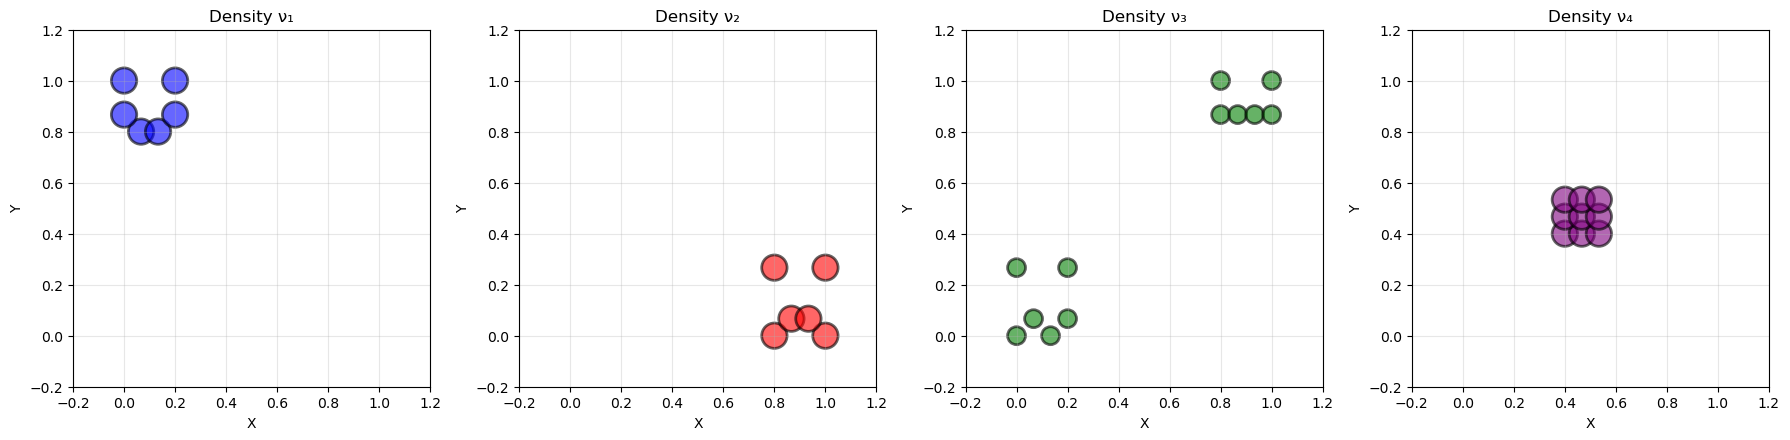

In [154]:

fig, axes = plt.subplots(1, M, figsize=(18, 5))

ax1 = axes[0]
scatter1 = ax1.scatter(X_grid.flatten(), Y_grid.flatten(), 
                       s=q1*2000, c='blue', alpha=0.6, edgecolors='black', linewidth=2)
ax1.set_xlim(-0.2, 1.2)
ax1.set_ylim(-0.2, 1.2)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Density ν₁')
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')


ax2 = axes[1]
scatter2 = ax2.scatter(X_grid.flatten(), Y_grid.flatten(), 
                       s=q2*2000, c='red', alpha=0.6, edgecolors='black', linewidth=2)
ax2.set_xlim(-0.2, 1.2)
ax2.set_ylim(-0.2, 1.2)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Density ν₂')
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')
        
ax3 = axes[2]
scatter3 = ax3.scatter(X_grid.flatten(), Y_grid.flatten(),
                          s=q3*2000, c='green', alpha=0.6, edgecolors='black', linewidth=2)
ax3.set_xlim(-0.2, 1.2)
ax3.set_ylim(-0.2, 1.2)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_title('Density ν₃')
ax3.grid(True, alpha=0.3)
ax3.set_aspect('equal')

ax4 = axes[3]
scatter4 = ax4.scatter(X_grid.flatten(), Y_grid.flatten(),
                          s=q4*2000, c='purple', alpha=0.6, edgecolors='black', linewidth=2)
ax4.set_xlim(-0.2, 1.2)
ax4.set_ylim(-0.2, 1.2)
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_title('Density ν₄')
ax4.grid(True, alpha=0.3)
ax4.set_aspect('equal')

plt.tight_layout()
plt.show()

The problem considered is EXACT (non convex barycenter problem with free support), then the suport size is 3721
Computing distance matrix...
The computation time of the method starts now, but 0.0s have been dedicated to initialization (matrix constructions)
1: computed in 0.01s; (?)stopping criteria=0.0006394911662362963
2: computed in 0.01s; (?)stopping criteria=6.951395605346382e-05
3: computed in 0.01s; (?)stopping criteria=5.0921214670439894e-05
4: computed in 0.0s; (?)stopping criteria=4.180401574370256e-05
5: computed in 0.01s; (?)stopping criteria=4.273547675790238e-05
6: computed in 0.01s; (?)stopping criteria=4.037621702472182e-05
7: computed in 0.01s; (?)stopping criteria=3.647413500980877e-05
8: computed in 0.0s; (?)stopping criteria=3.252587536735688e-05
9: computed in 0.01s; (?)stopping criteria=2.9438376372797198e-05
10: computed in 0.01s, WD = 0.9452229875159515, with distB=0.0024344802198994217; (?)stopping criteria=2.7029495916357162e-05
11: computed in 0.01s; (?)stopp

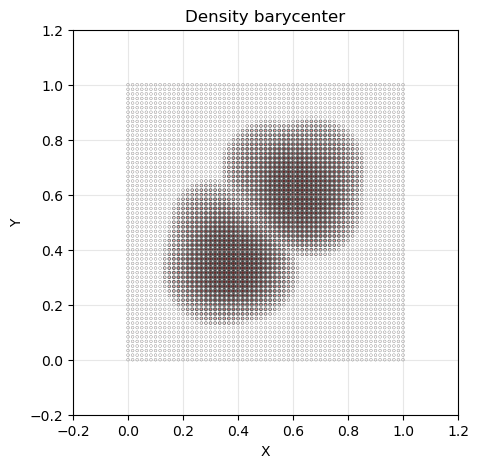

In [155]:
b = [q1, q2, q3, q4]

p, P, Time, Wdist, l_precisionB, Precision, Iterations, total_time, iterations_k = MAM(
    b=b,
    M_dist=False,     
    exact=True,  
    rho=10000,        
    gamma=0,          
    keep_track=True,  
    evry_it=10,        
    visualize=False,   
    precision=1e-6,
    iterations_min=5,
    iterations_max=200,
    computation_time=10
)

x = np.linspace(0, 1, int(np.sqrt(p.shape[0]))) 
y = np.linspace(0, 1, int(np.sqrt(p.shape[0])))
X_grid, Y_grid = np.meshgrid(x, y)
fig, ax = plt.subplots(1, 1, figsize=(18, 5))

scatter = ax.scatter(X_grid.flatten(), Y_grid.flatten(),s=p * 2000,c='red',alpha=0.6,edgecolors='black',linewidth=2)

ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-0.2, 1.2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Density barycenter')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.show()

Now we merge our projection to the MAM function:

In [156]:
def division_tasks(nb_tasks, pool_size):
    """
    Inputs: (int)
    *nb_tasks
    *pool_size : number of CPU/GPU to divide the tasks between

    Outputs:
    rearranged: numpy list of lists so that rearranged[i] should be treated by CPU[i] (rank=i)
    """
    # The tasks can be equaly divided for each CPUs
    if nb_tasks % pool_size == 0:
        rearranged = np.array([i for i in range(nb_tasks)])
        rearranged = np.split(rearranged, pool_size)

    # Some CPUs will receive more tasks
    else:
        div = nb_tasks // pool_size
        congru = nb_tasks % pool_size
        rearranged1 = np.array([i for i in range(div * congru + congru)])
        rearranged1 = np.split(rearranged1, congru)
        rearranged2 = np.array([i for i in range(div * congru + congru, nb_tasks)])
        rearranged2 = np.split(rearranged2, pool_size - congru)
        rearranged = rearranged1 + rearranged2

    # Output:
    return (rearranged)


def build_M_dist(rank, splitting_work, pool_size, comm, R, S, b, exact=False):
    """
    The distance matrix is build in rank 0 and then it is split with the other processors
    but only the interesting parts of the matrix are shared.
    Then the original distance matrix is delate.
    """
    if rank == 0:
        print('Computing distance matrix...')
        sys.stdout.flush()
        # only one processor build the large distance matrix
        M = len(b)
        M_dist = distance_matrix(M, S, exact) / S  # .astype(np.float16)
        # share the distance matrices between the processors:
        # share_M_btw_procs(M_dist, b, R, splitting_work)
        Mat_dist = {}
        S = {}
        # Sharing the matrix distance to each ranks (but only with the needed columns)
        for rg in range(1, pool_size):
            for m in splitting_work[rg]:
                I = b[m] > 0
                S[m] = np.sum(I)
                Mat_dist[m] = np.reshape(M_dist[:, I], (R * S[m],))
            # sending the matrix
            comm.send(S, dest=rg)
            comm.send(Mat_dist, dest=rg)
            S = {}
            Mat_dist = {}
        # same but direct for rank 0
        for m in splitting_work[0]:
            I = b[m] > 0
            S[m] = np.sum(I)
            Mat_dist[m] = M_dist[:, I]
        # delate the large M_dist
        del M_dist

    # receiving the matrices
    if rank != 0:
        S = comm.recv(source=0)
        Mat_dist = comm.recv(source=0)
        print(rank, S, splitting_work[rank], Mat_dist.keys())
        sys.stdout.flush()
        for m in splitting_work[rank]:
            print(m, S[m])
            sys.stdout.flush()
            Mat_dist[m] = np.reshape(Mat_dist[m], (R, S[m]))

    # Output
    return(Mat_dist)

In [157]:
def MAM_frob(b, M_dist=False, exact=False,
        rho=1000, gamma=0,
        keep_track=True, evry_it = 10, name='mam.pkl',
        visualize=False,
        precision=10**-4,
        computation_time=100, iterations_min=3, iterations_max=1000,
        tau_frobenius=0.5):
    """
    This version of mam adresses pb with very large but preferably sparse support. In this case the distance matrix are computed one 
    by one (instead of building a huge distance matrix and only using the sparse rare columns)
    Input:
    *b: (resolution x n) vector collection of n probability distribution.
    *M_dist:( resolution x resolution) is the distance matrix between every supports.
    /!\ Note that M_dist can be a dictionary where M_dist[m] is the distance matrix between the support barycenter and the measure m.
    *exact: (bool) if True we use the free support method (large support considered, refer to Bogward), else fixed support, 
    meaning we keep the same support than have the b[i]s for the barycenter.
    *rho: (float) is an hyperparameter that is linked to the convergence speed but has no impact on the solution
    if rho is precised in the arguments of the function then this rho will be used
    * gamma: (float) value of the unbalanced parameter, if gamma=0, mam treats the balanced barycenter problem
    * keep_track: (bool) should we keep records of the past barycenter approximations and other datas.
    * evry_it: (int) the datas are saved every evry_it iterations
    * name: (str) name of the saved data in the current repository
    * visualize: (bool) if True an approximation of the barycenter is displayed (usefull if image datas are treated)
    * computation_time: (float) maximal computation time in seconds
    * iterations_min: (int) minimal number of iterations
    * iterations_max: (int) maximal number of iterations
    * precision: (float) stopping criteria based on the fixed point method, using the norm max

    Output: p, P, Time, Wdist, l_precisionB, Precision, Iterations, total_time, iterations_k
    * p: (R x 1) the probability distribution of the calculated barycenter
    * P: (R x iterations_k) matrix that store 'p_' after eache iteration of the algorithm
    * Time: (1 x iterations_k) execution time of each iteration
    * Wdist: (1 x iterations_k) evolution of the approximated Wasserstein barycenter distance
    * l_precisionB: (1 x iterations_k) evolution of the evaluation of the accuracy of the approximated Wasserstein barycenter distance
    * Precision: (1 x iterations_k) evolution of the norm max stopping criterion 
    * Iterations: (1 x iterations_k) number of the saved iterations
    * total_time: (float) total computation time
    *iterations_k: (int) number of iterations 
    
    NB: it is possible to save the Pi's: the transport matrices between p and the probability densities

    Infos:
    Refer to the article: "Mimouni, D., Malisani, P., Zhu, J., & de Oliveira, W. (2024). Computing Wasserstein Barycenter
    via operator splitting: the method of averaged marginals. arXiv preprint arXiv:2309.05315."

    (c) Daniel Mimouni 2024
    """""

    st00 = time.time()

    # Parameter initializations
    # Number of probability distributions
    M = len(b)

    # Parallelization initialization:
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    pool_size = comm.Get_size()
    splitting_work = division_tasks(M, pool_size)

    # Dimension of the pictures
    S = int(b[0].shape[0])

    # Dimension of the support of the targeted barycenter
    # According to Anderes and Borgwardt in 'DiscreteWasserstein barycenters: optimal transport for discrete data'
    # we only need to consider a support size of this size to solve the exact (non convex) pb
    if exact:
        R = ( int(S**.5)*M - M + 1 )**2
        if rank==0:
            print(f'The problem considered is EXACT (non convex barycenter problem with free support), then the suport size is {R}')
            sys.stdout.flush()
    # but if we do not need the exact resolution of the convexe problem we can look for a solution on the same support size as the inital images
    if not exact:
        R = S
        if rank==0:
            print(f'The problem considered is the convex barycenter problem: fixed support of size {R}')
            sys.stdout.flush()

    # I compute the distance matrix for a 2D problem if the distance matrix is not given
    # if a 3D pb is at hand, one should provide the M_dist for e.g.
    try: # see if M_dist is defined
        if type(M_dist) == dict:
            Mat_dist = M_dist
        if type(M_dist) != dict:
            var = M_dist.shape
            for m in splitting_work[rank]:
                I = b[m] > 0
                Mat_dist[m] = M_dist[:, I]
    except: #M_dist is not defined and need to be built (as a matrix then split as a dict)
        Mat_dist = build_M_dist(rank, splitting_work, pool_size, comm, R, S, b, exact)


    # storage of the transport plans
    theta = {}
    S = {}
    sum_theta_mean_local = 0
    inv_sum_S_local = 0
    # PARALLELIZATION
    # iterate over probabilities
    splitting_work = division_tasks(M, pool_size)
    for m in splitting_work[rank]:

        S[m] = np.sum(b[m] > 0)
        inv_sum_S_local = inv_sum_S_local + 1 / S[m]

        # Stored in a dictionnary
        theta[m] = -1 / rho * Mat_dist[m]

        # to compute p
        sum_theta_mean_local = sum_theta_mean_local + np.mean(theta[m], axis=1)

    # Gather and bcast the local solutions
    # Gather and get the sum of the inv_sum_S:
    inv_sum_S = comm.gather(inv_sum_S_local, root=0)
    inv_sum_S = np.sum(inv_sum_S)
    # Bcast:
    inv_sum_S = comm.bcast(inv_sum_S, root=0)
    # Gather and get the sum of the theta_mean's:
    l_sum_theta_mean = comm.gather(sum_theta_mean_local, root=0)
    l_sum_theta_mean = np.array(l_sum_theta_mean)
    sum_theta_mean = np.sum(l_sum_theta_mean, axis=0)
    # Bcast:
    sum_theta_mean = comm.bcast(sum_theta_mean, root=0)

    # probability:
    p = sum_theta_mean / inv_sum_S


    st1 = time.time()
    if rank==0:
        print(f'The computation time of the method starts now, but {np.round(time.time() - st00)}s have been dedicated to initialization (matrix constructions)')
        sys.stdout.flush()


    # Keep track:
    size_saving = iterations_max // evry_it
    if keep_track:
        P = np.zeros((R, size_saving + 1))  # barycentric probability measure
        Time = np.zeros(size_saving + 1)  # time per iteration
        Precision = np.zeros(size_saving + 1)  # precision after each iteration
        Wdist = np.zeros(size_saving + 1)
        l_precisionB = np.zeros(size_saving + 1)
        Iterations = np.zeros(size_saving + 1)

        # Pi = theta.copy()

    # Algorithm iterations:
    spent_time = 0
    iterations_k = 0
    it_save = 0
    while (iterations_k < iterations_min) or (spent_time < computation_time and iterations_k < iterations_max and evol_p>precision): # and count_stop<10):  #  # and evol_p>10**-6) : # and evol_p>10**-16
        iterations_k = iterations_k + 1

        # print('~'*20 +  f" \n Step {k} ...")
        start = time.time()

        # Initialize for inner loops
        sum_theta_mean_local = np.zeros(R)
        if keep_track:
            m_theta = {}
            WD = 0

        # Unbalanced Wasserstein barycenter -> Computing coefficient t:
        t = 1  # if balanced Wasserstein barycenter
        if gamma > 0 and iterations_k > 1:  # if unbalanced
            # Compute t_unbalanced
            coeff_unbalanced_local = 0
            for m in splitting_work[rank]:
                coeff_unbalanced_local = coeff_unbalanced_local + np.linalg.norm(
                    np.sum(theta[m], axis=1) - p) ** 2 / S[m]
            # Gather
            coeff_unbalanced = comm.gather(coeff_unbalanced_local, root=0)
            coeff_unbalanced = np.array(coeff_unbalanced)
            coeff_unbalanced = np.sum(coeff_unbalanced, axis=0)
            # Bcast:
            coeff_unbalanced = comm.bcast(coeff_unbalanced, root=0)

            # Define unbalanced coefficient
            t = min(1, gamma / rho / coeff_unbalanced ** .5)


        # PARALLELIZATION
        # iterate over probabilities
        for m in splitting_work[rank]:
            # index of M_dist I use
            I = b[m] > 0

            # Get the new theta[m]
            # deltaU
            deltaU = ( p - np.sum(theta[m], axis=1) ) / S[m]
            deltaU = np.expand_dims(deltaU, axis=1)
            # W for the projection
            theta[m] = theta[m] - 1 / rho * Mat_dist[m] + 2 * t * deltaU
            # W get normalized before its projection onto the simplex

            # theta[m] = theta[m] / b[m][I]
            # the transport plan is un-normalized after the projection onto the simplex
            # theta[m] = projection_simplex(theta[m], z=1, axis=0) * b[m][I]
            #MY CHANGE  
            theta[m] = proximal_gradient_transport_projection(
                                                                    pi=theta[m],
                                                                    nu=p,
                                                                    mu=b[m][I],
                                                                    tau=tau_frobenius
                                                                )

            # Pi[m] = theta[m].copy()
            # this is to evaluate the algorithm advancement
            if keep_track:
                m_theta[m] = np.sum(theta[m], axis=1)
                WD += np.sum( np.multiply(theta[m], Mat_dist[m]) )

            theta[m] = theta[m] - t * deltaU

            # mean of theta:
            sum_theta_mean_local = sum_theta_mean_local + np.mean(theta[m], axis=1) # equivalent to: np.sum(theta[m], axis=1) /S[m]

        # Gather and bcast the local solutions (marginals)
        # Gather and get the sum of the theta_mean's:
        l_sum_theta_mean = comm.gather(sum_theta_mean_local, root=0)
        l_sum_theta_mean = np.array(l_sum_theta_mean)
        sum_theta_mean = np.sum(l_sum_theta_mean, axis=0)
        # Bcast:
        sum_theta_mean = comm.bcast(sum_theta_mean, root=0)

        # Stopping criterion: using the norm max
        evol_p = np.max(np.abs(p - sum_theta_mean / inv_sum_S))

        # Compute the approximated barycenter:
        p = sum_theta_mean / inv_sum_S

        # Time management: Here is the end of 1 iteration
        end = time.time()
        iteration_time = np.round((end - start), 2)


        #### Keep Track ###
        if rank==0 and iterations_k%evry_it != 0:
            print(f'{iterations_k}: computed in {iteration_time}s; (?)stopping criteria={evol_p}')
            sys.stdout.flush()
        # Save datas
        if keep_track and iterations_k%evry_it == 0:
            # show avancement of the barycenter
            if rank == 0:
                if visualize:
                    plt.close()
                    plt.figure()
                    plt.imshow(np.reshape(p, (int(R**.5),int(R**.5))), cmap='hot_r')
                    plt.colorbar()
                    plt.pause(0.1)

            # Compute some precision variables
            theta1m = np.zeros(R)
            for m in splitting_work[rank]:
                theta1m = theta1m + m_theta[m] / S[m]
            l_theta1m = comm.gather(theta1m, root=0)
            theta1m = np.array(l_theta1m)
            theta1m = np.sum(theta1m, axis=0)
            theta1m = comm.bcast(theta1m, root=0)
            theta1m = theta1m / inv_sum_S
            # Compute the distance of the marginals of theta after the projection onto the simplex, to the subset B:
            distB = 0
            for m in splitting_work[rank]:
                distB += np.linalg.norm(m_theta[m] - theta1m)**2 / S[m]
            l_distB = comm.gather(distB, root=0)
            distB = np.array(l_distB)
            distB = np.sum(distB)
            distB = comm.bcast(distB, root=0)
            distB = distB**0.5

            # Compute the approximated distance:
            l_WD = comm.gather(WD, root=0)
            l_WD = np.array(l_WD)
            WD = np.sum(l_WD)
            # Bcast:
            WD = comm.bcast(WD, root=0) #/ M

            # Fill the matrices
            P[:, it_save] = p
            Time[it_save] = iteration_time
            Precision[it_save] = evol_p
            Wdist[it_save] = WD
            l_precisionB[it_save] = distB
            Iterations[it_save] = iterations_k
            it_save += 1

            # Save results
            if rank==0:
                print(f'{iterations_k}: computed in {iteration_time}s, WD = {WD}, with distB={distB}; (?)stopping criteria={evol_p}')
                sys.stdout.flush()
                # save avancement:
                # save also ? P,
                l_res = [p, P, Time, Wdist, l_precisionB, Precision,
                         Iterations, np.round((end - st1) / 60, 2), iterations_k]
                with open(name, 'wb') as f:
                    pickle.dump(l_res, f)


        # manage time at a global scale:
        spent_time = end - st1
        spent_time = comm.bcast(spent_time , root=0)

    end = time.time()
    total_time = np.round((end - st1) / 60, 2)
    print(iterations_k)

    # Output
    return (p, P, Time, Wdist, l_precisionB, Precision, Iterations, total_time, iterations_k)  #Pi_tot

Lets prove it

In [167]:
p, P, Time, Wdist, l_precisionB, Precision, Iterations, total_time, iterations_k = MAM_frob(
    b=b,
    M_dist=False,     
    exact=True,  
    rho=10000,        
    gamma=0,          
    keep_track=True,  
    evry_it=10,        
    visualize=False,   
    precision=1e-6,
    iterations_min=5,
    iterations_max=200,
    computation_time=10,
    tau_frobenius=50.0
)

The problem considered is EXACT (non convex barycenter problem with free support), then the suport size is 961
Computing distance matrix...
The computation time of the method starts now, but 0.0s have been dedicated to initialization (matrix constructions)
1: computed in 8.89s; (?)stopping criteria=0.00043671875000000015
2: computed in 22.94s; (?)stopping criteria=8.131516293641283e-20
3: computed in 25.27s; (?)stopping criteria=8.131516293641283e-20
4: computed in 22.36s; (?)stopping criteria=8.131516293641283e-20
5: computed in 23.62s; (?)stopping criteria=8.131516293641283e-20
5


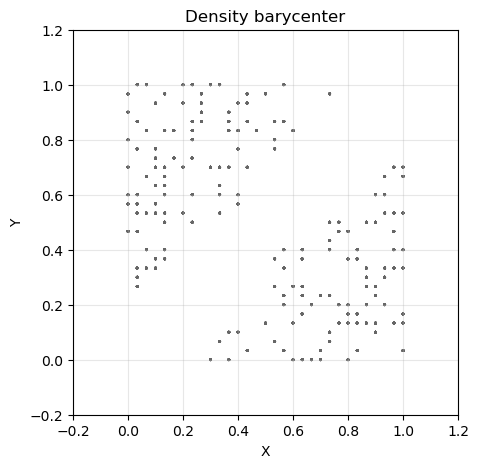

In [168]:
x = np.linspace(0, 1, int(np.sqrt(p.shape[0]))) 
y = np.linspace(0, 1, int(np.sqrt(p.shape[0])))
X_grid, Y_grid = np.meshgrid(x, y)
fig, ax = plt.subplots(1, 1, figsize=(18, 5))

scatter = ax.scatter(X_grid.flatten(), Y_grid.flatten(),s=p * 2000,c='red',alpha=0.6,edgecolors='black',linewidth=2)

ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-0.2, 1.2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Density barycenter')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.show()

### Experiment II

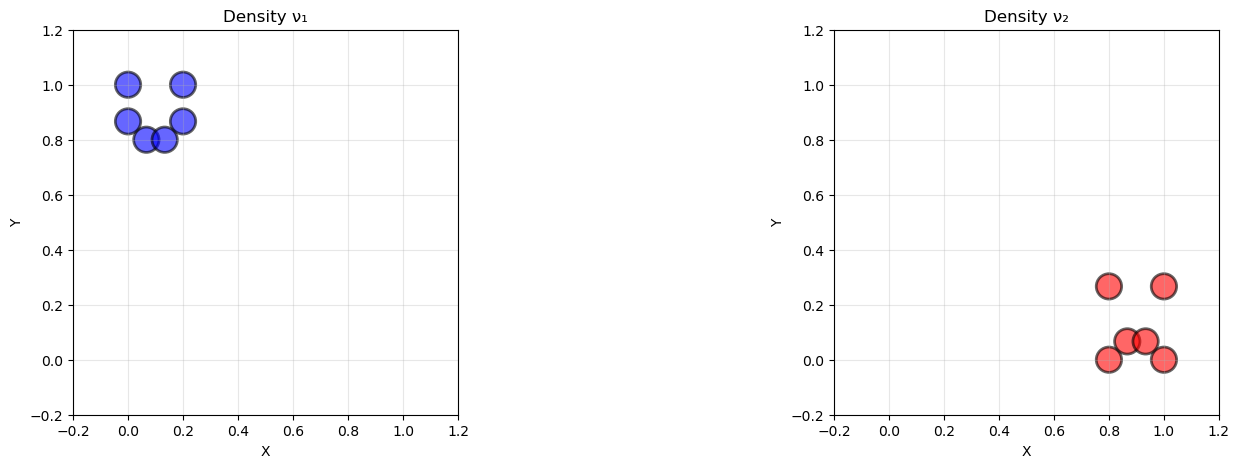

In [169]:
M = 2 # number of measures
S = 16*16 
K = 16

x = np.linspace(0, 1, 16)
y = np.linspace(0, 1, 16)
X_grid, Y_grid = np.meshgrid(x, y)
pos = np.dstack((X_grid, Y_grid))

q1 = np.zeros((16, 16))
q1[15, 0] = 1/6
q1[15, 3] = 1/6
q1[13,0] = 1/6
q1[13,3] = 1/6
q1[12,1] = 1/6
q1[12,2] = 1/6
q1 = q1.flatten()

q2 = np.zeros((16, 16))
q2[4, 12] = 1/6
q2[4, 15] = 1/6
q2[0,12] = 1/6
q2[1,13] = 1/6
q2[1,14] = 1/6
q2[0,15] = 1/6
q2 = q2.flatten()  


fig, axes = plt.subplots(1, M, figsize=(18, 5))

ax1 = axes[0]
scatter1 = ax1.scatter(X_grid.flatten(), Y_grid.flatten(), 
                       s=q1*2000, c='blue', alpha=0.6, edgecolors='black', linewidth=2)
ax1.set_xlim(-0.2, 1.2)
ax1.set_ylim(-0.2, 1.2)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Density ν₁')
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')


ax2 = axes[1]
scatter2 = ax2.scatter(X_grid.flatten(), Y_grid.flatten(), 
                       s=q2*2000, c='red', alpha=0.6, edgecolors='black', linewidth=2)
ax2.set_xlim(-0.2, 1.2)
ax2.set_ylim(-0.2, 1.2)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Density ν₂')
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')

The problem considered is EXACT (non convex barycenter problem with free support), then the suport size is 961
Computing distance matrix...
The computation time of the method starts now, but 0.0s have been dedicated to initialization (matrix constructions)
1: computed in 0.0s; (?)stopping criteria=0.001401129601326743
2: computed in 0.0s; (?)stopping criteria=0.00016992187500000048
3: computed in 0.0s; (?)stopping criteria=0.00016297818548627357
4: computed in 0.0s; (?)stopping criteria=0.00012639112458844373
5: computed in 0.0s; (?)stopping criteria=0.00010079346026494829
6: computed in 0.01s; (?)stopping criteria=8.814892869325503e-05
7: computed in 0.0s; (?)stopping criteria=8.520860169300296e-05
8: computed in 0.0s; (?)stopping criteria=8.211169267809322e-05
9: computed in 0.0s; (?)stopping criteria=7.905187806904034e-05
10: computed in 0.01s, WD = 0.740878985816565, with distB=8.648517350001761e-05; (?)stopping criteria=7.589405303486119e-05
11: computed in 0.0s; (?)stopping crite

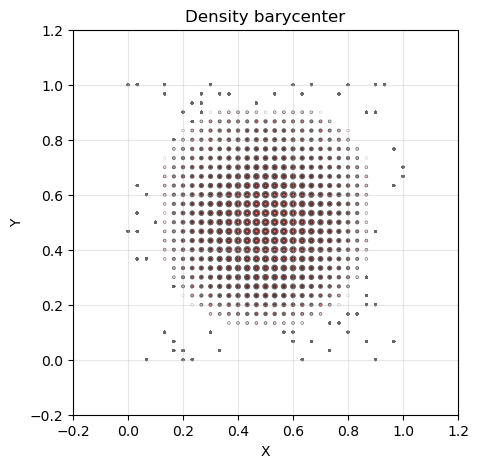

In [171]:
b = [q1, q2]

p, P, Time, Wdist, l_precisionB, Precision, Iterations, total_time, iterations_k = MAM(
    b=b,
    M_dist=False,     
    exact=True,  
    rho=10000,        
    gamma=0,          
    keep_track=True,  
    evry_it=10,        
    visualize=False,   
    precision=1e-6,
    iterations_min=5,
    iterations_max=200,
    computation_time=10,
    
)

x = np.linspace(0, 1, int(np.sqrt(p.shape[0]))) 
y = np.linspace(0, 1, int(np.sqrt(p.shape[0])))
X_grid, Y_grid = np.meshgrid(x, y)
fig, ax = plt.subplots(1, 1, figsize=(18, 5))

scatter = ax.scatter(X_grid.flatten(), Y_grid.flatten(),s=p * 2000,c='red',alpha=0.6,edgecolors='black',linewidth=2)

ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-0.2, 1.2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Density barycenter')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.show()

The problem considered is EXACT (non convex barycenter problem with free support), then the suport size is 961
Computing distance matrix...
The computation time of the method starts now, but 0.0s have been dedicated to initialization (matrix constructions)
1: computed in 22.44s; (?)stopping criteria=0.00043671875000000015
2: computed in 21.89s; (?)stopping criteria=8.131516293641283e-20
3: computed in 28.28s; (?)stopping criteria=8.131516293641283e-20
4: computed in 27.81s; (?)stopping criteria=8.131516293641283e-20
5: computed in 19.92s; (?)stopping criteria=8.131516293641283e-20
5


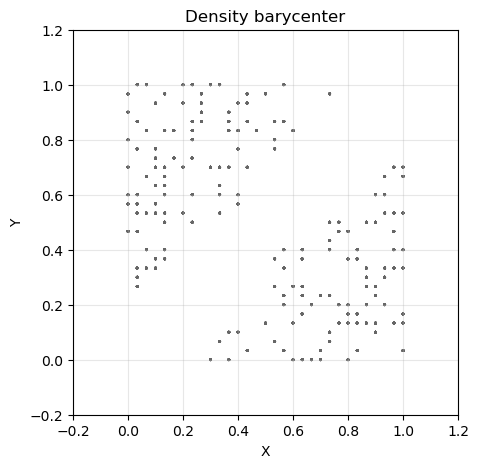

In [172]:
b = [q1, q2]

p, P, Time, Wdist, l_precisionB, Precision, Iterations, total_time, iterations_k = MAM_frob(
    b=b,
    M_dist=False,     
    exact=True,  
    rho=10000,        
    gamma=0,          
    keep_track=True,  
    evry_it=10,        
    visualize=False,   
    precision=1e-6,
    iterations_min=5,
    iterations_max=200,
    computation_time=10,
    tau_frobenius=500.0
)

x = np.linspace(0, 1, int(np.sqrt(p.shape[0]))) 
y = np.linspace(0, 1, int(np.sqrt(p.shape[0])))
X_grid, Y_grid = np.meshgrid(x, y)
fig, ax = plt.subplots(1, 1, figsize=(18, 5))

scatter = ax.scatter(X_grid.flatten(), Y_grid.flatten(),s=p * 2000,c='red',alpha=0.6,edgecolors='black',linewidth=2)

ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-0.2, 1.2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Density barycenter')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.show()